<a href="https://colab.research.google.com/github/chirazedrine/EmoGen/blob/main/EmoGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0: Dowload dependencies

In [8]:
!pip install torch torchvision

# Step 1: Download and extract the dataset

In [9]:
!wget -O EmoSet-118K.zip "https://www.dropbox.com/scl/fi/myue506itjfc06m7svdw6/EmoSet-118K.zip?dl=1&rlkey=7f3oyjkr6zyndf0gau7t140rv"


--2024-03-23 23:53:25--  https://www.dropbox.com/scl/fi/myue506itjfc06m7svdw6/EmoSet-118K.zip?dl=1&rlkey=7f3oyjkr6zyndf0gau7t140rv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb9e2616d04ab266f70587f6a2f.dl.dropboxusercontent.com/cd/0/inline/CPo4Ybf0sWG87WXlQAspbgX4wIrty1nfsh-xpcKLzHjfYFECuaF0haamcWS8DsqMaV8EhvejQa9X2tWnGDaie4K6PqVCv6QjnqqZGAqpA2cMAvN6WzE8yW9znV6jr21Yjts_vcbmPrg-ziJXdpT8H8L8/file?dl=1# [following]
--2024-03-23 23:53:26--  https://ucb9e2616d04ab266f70587f6a2f.dl.dropboxusercontent.com/cd/0/inline/CPo4Ybf0sWG87WXlQAspbgX4wIrty1nfsh-xpcKLzHjfYFECuaF0haamcWS8DsqMaV8EhvejQa9X2tWnGDaie4K6PqVCv6QjnqqZGAqpA2cMAvN6WzE8yW9znV6jr21Yjts_vcbmPrg-ziJXdpT8H8L8/file?dl=1
Resolving ucb9e2616d04ab266f70587f6a2f.dl.dropboxusercontent.com (ucb9e2616d04ab266f70587f6a2f.dl.dropboxusercontent.com)... 16

In [10]:
!unzip -q EmoSet-118K.zip -d /content/EmoSet-118K/

replace /content/EmoSet-118K/annotation/amusement/amusement_00000.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Step 2: Parse the JSON files to create a mapping for image paths and labels

In [11]:
import os
import json
import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn

base_path = '/content/EmoSet-118K'
annotations_dir = os.path.join(base_path, 'annotation')
images_dir = os.path.join(base_path, 'image')

# Parse JSON annotations
def parse_annotations(annotations_dir):
    annotations = []
    for emotion_dir_name in os.listdir(annotations_dir):
        emotion_dir_path = os.path.join(annotations_dir, emotion_dir_name)
        if os.path.isdir(emotion_dir_path):
            for annotation_file in os.listdir(emotion_dir_path):
                annotation_file_path = os.path.join(emotion_dir_path, annotation_file)
                with open(annotation_file_path, 'r') as f:
                    annotation_data = json.load(f)
                    annotations.append(annotation_data)
    return annotations

annotations = parse_annotations(annotations_dir)

# Verify the number of annotations loaded
print(f"Loaded {len(annotations)} annotations.")

# Extract unique emotions and create a mapping to indices
unique_emotions = sorted({anno['emotion'] for anno in annotations})
emotion_to_idx = {emotion: idx for idx, emotion in enumerate(unique_emotions)}
print(f"Unique emotions found: {list(emotion_to_idx.keys())}")

class EmoSetDataset(Dataset):
    def __init__(self, annotations, images_dir, transform=None):
        self.annotations = annotations
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        image_path = os.path.join(self.images_dir, annotation['emotion'], f"{annotation['image_id']}.jpg")
        image = Image.open(image_path).convert('RGB')
        label = emotion_to_idx[annotation['emotion']]

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset and DataLoader
dataset = EmoSetDataset(annotations, images_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)


Loaded 118102 annotations.
Unique emotions found: ['amusement', 'anger', 'awe', 'contentment', 'disgust', 'excitement', 'fear', 'sadness']


# Step 3-4: Define the CNN model for emotion classification

In [12]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch import nn, optim

# Load pre-trained EfficientNet-B0 model
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)

# Replace the classifier to match the number of unique emotions
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(unique_emotions))

# Setup device: Use GPU if available, else fall back to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Move model to the appropriate device
model = model.to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 116MB/s] 


Using device: cuda


In [13]:
!pip install tqdm

# Step 5-6: training and validation


In [14]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import json
from PIL import Image

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / labels.size(0)

# Load pre-trained EfficientNet-B0 model
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)

# Replace the classifier to match the number of unique emotions
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(unique_emotions))

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Transformations for validation and test sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Split annotations into training and validation
train_annos, val_annos = train_test_split(annotations, test_size=0.2, random_state=42)

# Create datasets and data loaders for training and validation
train_dataset = EmoSetDataset(train_annos, images_dir, transform=train_transforms)
val_dataset = EmoSetDataset(val_annos, images_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training and validation loop with early stopping
num_epochs = 5
best_val_accuracy = 0

for epoch in range(num_epochs):
    model.train()
    total_train_loss, total_train_accuracy = 0, 0

    for inputs, labels in tqdm(train_loader, desc=f'Training Epoch {epoch+1}'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * inputs.size(0)
        total_train_accuracy += calculate_accuracy(outputs, labels) * inputs.size(0)

    epoch_loss = total_train_loss / len(train_loader.dataset)
    epoch_accuracy = total_train_accuracy / len(train_loader.dataset)
    print(f'Training - Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    # Validation phase
    model.eval()
    total_val_loss, total_val_accuracy = 0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item() * inputs.size(0)
            total_val_accuracy += calculate_accuracy(outputs, labels) * inputs.size(0)

    val_epoch_loss = total_val_loss / len(val_loader.dataset)
    val_epoch_accuracy = total_val_accuracy / len(val_loader.dataset)
    print(f'Validation - Epoch {epoch+1}, Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_accuracy:.4f}')

    if val_epoch_accuracy > best_val_accuracy:
        best_val_accuracy = val_epoch_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved with Accuracy:", best_val_accuracy)



Training Epoch 1: 100%|██████████| 2953/2953 [14:21<00:00,  3.43it/s]


Training - Epoch 1, Loss: 1.2084, Accuracy: 0.5645


Validation: 100%|██████████| 739/739 [03:37<00:00,  3.40it/s]


Validation - Epoch 1, Loss: 0.9740, Accuracy: 0.6509
Best model saved with Accuracy: 0.650946191947843


Training Epoch 2: 100%|██████████| 2953/2953 [14:20<00:00,  3.43it/s]


Training - Epoch 2, Loss: 1.0862, Accuracy: 0.6062


Validation: 100%|██████████| 739/739 [03:40<00:00,  3.35it/s]


Validation - Epoch 2, Loss: 0.9186, Accuracy: 0.6677
Best model saved with Accuracy: 0.6676685999745988


Training Epoch 3: 100%|██████████| 2953/2953 [14:19<00:00,  3.44it/s]


Training - Epoch 3, Loss: 1.0342, Accuracy: 0.6271


Validation: 100%|██████████| 739/739 [03:41<00:00,  3.34it/s]


Validation - Epoch 3, Loss: 0.9012, Accuracy: 0.6761
Best model saved with Accuracy: 0.6761356420134625


Training Epoch 4: 100%|██████████| 2953/2953 [14:20<00:00,  3.43it/s]


Training - Epoch 4, Loss: 0.9963, Accuracy: 0.6397


Validation: 100%|██████████| 739/739 [03:41<00:00,  3.34it/s]


Validation - Epoch 4, Loss: 0.8656, Accuracy: 0.6875
Best model saved with Accuracy: 0.68748147834554


Training Epoch 5: 100%|██████████| 2953/2953 [14:18<00:00,  3.44it/s]


Training - Epoch 5, Loss: 0.9656, Accuracy: 0.6482


Validation: 100%|██████████| 739/739 [03:37<00:00,  3.40it/s]


Validation - Epoch 5, Loss: 0.8470, Accuracy: 0.6943
Best model saved with Accuracy: 0.6942974471868253


NameError: name 'test_loader' is not defined

In [17]:
!pip install tqdm

In [18]:
from tqdm import tqdm
if "test_loader" not in globals():
    raise NameError("test_loader is not defined. Please ensure you have loaded the test dataset.")

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_running_corrects = 0

for inputs, labels in tqdm(test_loader, desc="Evaluating"):
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        test_running_corrects += calculate_accuracy(outputs, labels) * inputs.size(0)

test_accuracy = test_running_corrects / len(test_loader.dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

NameError: test_loader is not defined. Please ensure you have loaded the test dataset.

# Step 7: Predict emotion for new images

In [34]:
import torch
from torchvision import transforms
from torchvision.models import efficientnet_b0
from torch import nn
from PIL import Image
import os
import pandas as pd

# Set up device, model, and transformations as before
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = efficientnet_b0(weights=None)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 8)
model_path = '/content/best_model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image.to(device)

def predict_emotion(image_path, model):
    idx_to_emotion = {
        0: 'Amusement',
        1: 'Anger',
        2: 'Awe',
        3: 'Contentment',
        4: 'Disgust',
        5: 'Excitement',
        6: 'Fear',
        7: 'Sadness'
    }
    image = preprocess_image(image_path)
    with torch.no_grad():
        outputs = model(image)
        _, predicted_idx = torch.max(outputs, 1)
        predicted_emotion = idx_to_emotion[predicted_idx.item()]
    return predicted_emotion

# New function to process a directory of images
def process_image_directory(directory_path, model):
    emotions = []
    for filename in os.listdir(directory_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(directory_path, filename)
            emotion = predict_emotion(file_path, model)
            emotions.append((filename, emotion))
    return pd.DataFrame(emotions, columns=['Filename', 'Predicted Emotion'])

# Example usage
directory_path = '/content/Inputs'
emotions_df = process_image_directory(directory_path, model)
print(emotions_df)


                             Filename Predicted Emotion
0                contentment_Muji.jpg           Sadness
1                  fear_thescream.jpg              Fear
2                   awe_ZahaHadid.jpg               Awe
3             amusement_BaloonDog.jpg         Amusement
4  disgust_Body Worlds Exhibition.jpg              Fear
5              sadness_sadManLamp.jpg              Fear


# Step 8: Generate plots

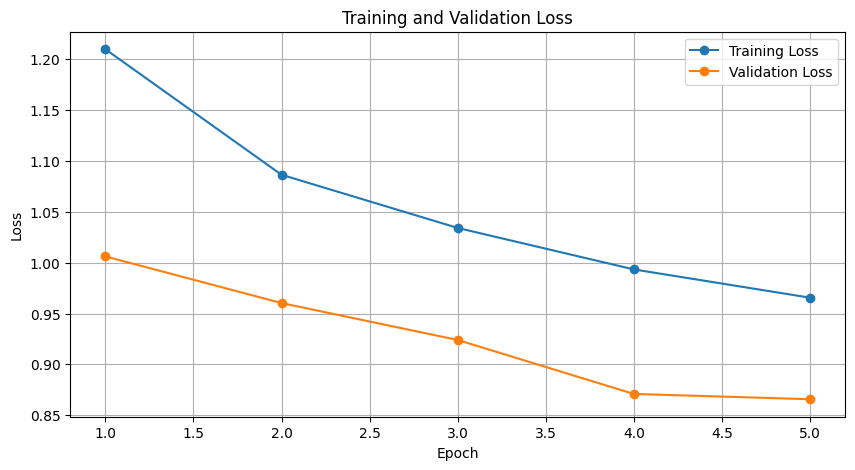

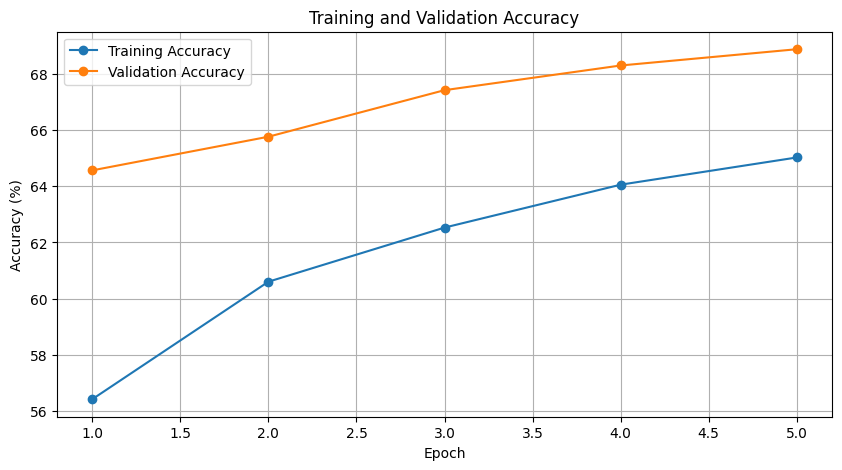

('/mnt/data/loss_plot.png', '/mnt/data/accuracy_plot.png')

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data for epochs, training/validation loss, and training/validation accuracy
epochs = np.arange(1, 6)
train_loss = [1.2100, 1.0865, 1.0342, 0.9934, 0.9656]
val_loss = [1.0062, 0.9603, 0.9240, 0.8709, 0.8657]
train_accuracy = [56.41, 60.60, 62.53, 64.06, 65.03]
val_accuracy = [64.57, 65.77, 67.43, 68.31, 68.89]

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'o-', label='Training Loss')
plt.plot(epochs, val_loss, 'o-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.savefig("/content/loss_plot.png")

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, 'o-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'o-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.savefig("/content/accuracy_plot.png")

# Show the plots
plt.show()

# Return paths to the generated plots
loss_plot_path = "/mnt/data/loss_plot.png"
accuracy_plot_path = "/mnt/data/accuracy_plot.png"
(loss_plot_path, accuracy_plot_path)